In [93]:
import pandas as pd

In [94]:
df = pd.read_excel('model_3.xlsx') # Считываем данные
df.head()

,id_pacienta,Vozrast,pol,staj,HbA1c,TTG,T4cv,rost,ves,Hb,...,bilirub_nepryam,VD,Angiodist,Angiopat,katapakta,miopiya,Vis(Lev),Vis(Prav),PNP_enmg,glukoza
0,301,7,0,0,15.8,3.55,12.9,128,24.0,116.0,...,0.0,-1,-1,1,-1,-1,0.4,1.0,1,1
1,301,7,0,5,12.4,5.04,15.4,127,26.0,137.0,...,0.0,-1,-1,-1,-1,-1,1.0,1.0,-1,1
2,301,8,0,16,10.3,2.11,13.5,133,30.0,127.0,...,0.0,-1,-1,-1,-1,-1,1.0,1.0,-1,1
3,301,8,0,11,0.0,0.00,0.0,130,28.0,138.0,...,0.0,-1,-1,1,-1,-1,1.0,1.0,-1,1
4,301,9,0,23,9.7,2.04,18.1,135,32.0,132.0,...,0.0,-1,1,-1,-1,-1,1.0,1.0,-1,-1


In [95]:
df['id_pacienta'].value_counts()

527      14
2440     14
2013     13
1544     13
12053    13
         ..
434       1
2413      1
2412      1
436       1
27009     1
Name: id_pacienta, Length: 828, dtype: int64

In [96]:
del df['id_pacienta']

In [97]:
X_angiopat = df.drop('Angiopat', axis = 1) # зависимые переменные
y_angiopat = df['Angiopat'] # независимая переменная
X_angiodist = df.drop('Angiodist', axis = 1) # зависимые переменные
y_angiodist = df['Angiodist'] # независимая переменная
X_vd = df.drop('VD', axis = 1) # зависимые переменные
y_vd = df['VD'] # независимая переменная

In [98]:
from sklearn.feature_selection import mutual_info_classif
mutual_info_classif(X_angiopat,y_angiopat) # вычисляем MI

array([0.02416526, 0.01757363, 0.        , 0.00110887, 0.        ,
       0.        , 0.01190706, 0.02291569, 0.00233522, 0.        ,
       0.0142912 , 0.        , 0.00165802, 0.00701795, 0.        ,
       0.00560519, 0.00423427, 0.01213634, 0.00383199, 0.01480585,
       0.        , 0.02183595, 0.00892346, 0.        , 0.        ,
       0.01547779, 0.00135103, 0.00467215, 0.        , 0.00493222,
       0.00308484, 0.0080339 , 0.00437893, 0.00099431, 0.11835404,
       0.        , 0.05523536, 0.02035138, 0.02761597, 0.        ,
       0.00467243])

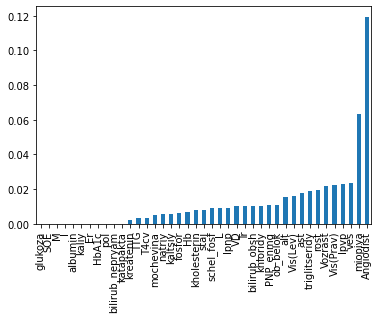

In [99]:
importances = pd.Series(mutual_info_classif(X_angiopat, y_angiopat), index=X_angiopat.columns) # записываем в Серию
importances.sort_values().plot.bar() # сортируем и рисуем столбиковую диаграмму

In [100]:
X_angiopat = X_angiopat[['Vozrast', 'Vis(Lev)', 'Vis(Prav)', 'Angiodist']]

In [101]:
# Проведем стандартизацию данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_angiopat = scaler.fit_transform(X_angiopat)

In [102]:
# Вопользуемся методом главных компонент и сократим данные до 2х компонент
from sklearn.decomposition import PCA
pca_angiopat = PCA(n_components = 2) # Cоздаем экземпляр класса, n_components - количества компонент
X_pca_angiopat = pca_angiopat.fit_transform(X_angiopat) # Трансформируем данные: из 46 признаков получаем 2
X_pca_angiopat # Значения компонент

array([[-0.39939302, -0.14412169],
       [ 0.42158529, -0.04600515],
       [ 0.46730362, -0.16929658],
       ...,
       [ 0.78733199, -1.03233665],
       [-0.23319726, -1.28944566],
       [-0.13992211,  1.40734722]])

In [103]:
# Запишем результат в новый DF и добавим столбец class
result_angiopat = pd.DataFrame()
result_angiopat['PC1'] = X_pca_angiopat[: , 0]
result_angiopat['PC2'] = X_pca_angiopat[: , 1]
result_angiopat['class'] = y_angiopat
result_angiopat.head()

,PC1,PC2,class
0,-0.399393,-0.144122,1
1,0.421585,-0.046005,-1
2,0.467304,-0.169297,-1
3,0.467304,-0.169297,1
4,0.532870,1.490309,-1


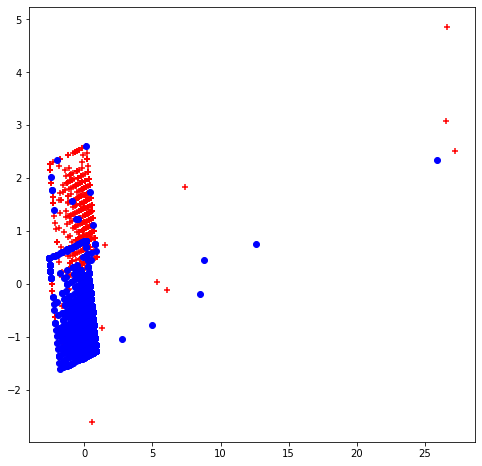

In [104]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
r1 = result_angiopat[result_angiopat['class'] == -1]
plt.scatter(r1['PC1'], r1['PC2'], c='r', marker='+')
r2 =  result_angiopat[result_angiopat['class'] == 1]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o')
plt.show()

In [105]:
# Уберем выбросы с помощью DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np
X = result_angiopat[['PC1', 'PC2']]
dbscan = DBSCAN(eps=1, min_samples=10) # Создаем экземпляр класса
labels = dbscan.fit_predict(X)
print('Получены кластеры:', np.unique(labels))
X['dbscan_lab'] = labels
X['class'] = y_angiopat

Получены кластеры: [-1  0]


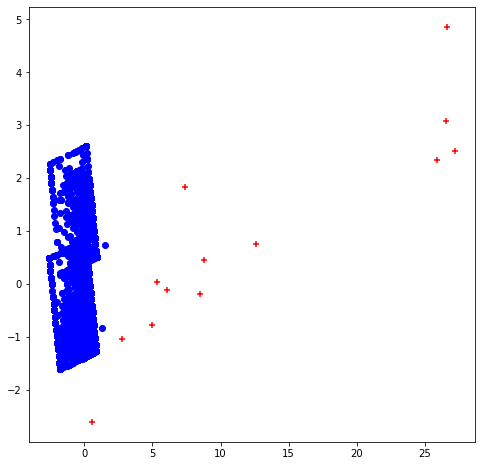

In [106]:
# Визуализируем
fig = plt.figure(figsize = (8,8))
r1 = X[X['dbscan_lab'] == -1]
plt.scatter(X['PC1'], X['PC2'], c='r', marker='+') # шум
r2 = X[X['dbscan_lab'] == 0]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o') # не шум
plt.show()

In [107]:
X = X[X['dbscan_lab'] == 0] # Возьмем только хорошие точки

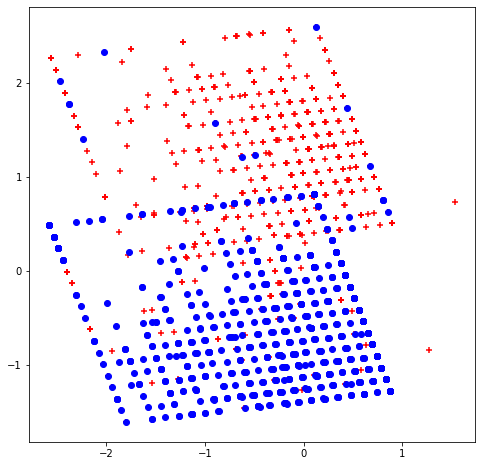

In [108]:
fig = plt.figure(figsize = (8,8))
r1 = X[X['class'] == -1]
plt.scatter(r1['PC1'], r1['PC2'], c='r', marker='+')
r2 = X[X['class'] == 1]
plt.scatter(r2['PC1'], r2['PC2'], c='b', marker='o')
plt.show()

In [109]:
X_train = X[['PC1', 'PC2']].values
y_train = X['class'].values 

In [110]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
def classification_report_with_accuracy_score(X_angiopat, y_angiopat):
    print (classification_report(X_angiopat, y_angiopat)) # print classification report
    return accuracy_score(X_angiopat, y_angiopat) # return accuracy score

In [111]:
#Модель логистической регрессии
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 0.1, max_iter=500, penalty='l1', solver= 'liblinear')
logreg = logreg.fit(X_train, y_train)

In [112]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(logreg, X_angiopat, y_angiopat, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.79      0.72      0.75       388
           1       0.56      0.65      0.60       211

    accuracy                           0.70       599
   macro avg       0.68      0.69      0.68       599
weighted avg       0.71      0.70      0.70       599

              precision    recall  f1-score   support

          -1       0.79      0.73      0.76       388
           1       0.56      0.63      0.60       211

    accuracy                           0.70       599
   macro avg       0.67      0.68      0.68       599
weighted avg       0.71      0.70      0.70       599

              precision    recall  f1-score   support

          -1       0.79      0.81      0.80       388
           1       0.64      0.61      0.62       211

    accuracy                           0.74       599
   macro avg       0.72      0.71      0.71       599
weighted avg       0.74      0.74      0.74       599

              preci

0.7115191986644407

In [113]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(logreg, X_angiopat, y_angiopat, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7103731226609364

In [114]:
#Модель случайного леса 
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,
                               criterion='entropy', 
                               min_samples_split=12)
forest = forest.fit(X_train, y_train)

In [115]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(forest,X_angiopat, y_angiopat, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.77      0.86      0.81       388
           1       0.67      0.54      0.59       211

    accuracy                           0.74       599
   macro avg       0.72      0.70      0.70       599
weighted avg       0.74      0.74      0.74       599

              precision    recall  f1-score   support

          -1       0.79      0.81      0.80       388
           1       0.63      0.61      0.62       211

    accuracy                           0.74       599
   macro avg       0.71      0.71      0.71       599
weighted avg       0.73      0.74      0.74       599

              precision    recall  f1-score   support

          -1       0.78      0.85      0.81       388
           1       0.67      0.55      0.60       211

    accuracy                           0.74       599
   macro avg       0.72      0.70      0.71       599
weighted avg       0.74      0.74      0.74       599

              preci

0.7382303839732888

In [116]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(forest, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7179338164463374

In [117]:
#Градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier
gradient = GradientBoostingClassifier(n_estimators=100,                                
                                    max_depth=7)
gradient = gradient.fit(X_train, y_train)

In [118]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(gradient,X_angiopat, y_angiopat, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.77      0.86      0.81       388
           1       0.67      0.52      0.59       211

    accuracy                           0.74       599
   macro avg       0.72      0.69      0.70       599
weighted avg       0.74      0.74      0.73       599

              precision    recall  f1-score   support

          -1       0.76      0.82      0.79       388
           1       0.62      0.52      0.57       211

    accuracy                           0.72       599
   macro avg       0.69      0.67      0.68       599
weighted avg       0.71      0.72      0.71       599

              precision    recall  f1-score   support

          -1       0.76      0.86      0.81       388
           1       0.66      0.49      0.56       211

    accuracy                           0.73       599
   macro avg       0.71      0.68      0.68       599
weighted avg       0.72      0.73      0.72       599

              preci

0.7292153589315525

In [119]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(gradient, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7111776141344694

In [120]:
#Адаптивный бустинг
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada = ada.fit(X_train, y_train)

In [121]:
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(ada, X_angiopat, y_angiopat, cv=5, scoring = make_scorer(classification_report_with_accuracy_score))
np.mean(cross)

              precision    recall  f1-score   support

          -1       0.76      0.84      0.80       388
           1       0.64      0.52      0.57       211

    accuracy                           0.73       599
   macro avg       0.70      0.68      0.69       599
weighted avg       0.72      0.73      0.72       599

              precision    recall  f1-score   support

          -1       0.79      0.84      0.81       388
           1       0.67      0.59      0.62       211

    accuracy                           0.75       599
   macro avg       0.73      0.71      0.72       599
weighted avg       0.75      0.75      0.75       599

              precision    recall  f1-score   support

          -1       0.78      0.85      0.81       388
           1       0.67      0.56      0.61       211

    accuracy                           0.75       599
   macro avg       0.73      0.71      0.71       599
weighted avg       0.74      0.75      0.74       599

              preci

0.7372287145242071

In [122]:
from sklearn.model_selection import cross_val_score
# Оценим качество с помощью перекрестной проверки и доли правильных ответов
cross = cross_val_score(ada, X_train, y_train, cv=5, scoring = 'f1_weighted')
np.mean(cross)

0.7348739717638111